In [ ]:
# скачиваем файлы
!wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O train_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O train_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O test_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O test_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O sample_submission.csv

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set()

%matplotlib inline

In [2]:
INPUT_DIR = '.'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))

In [3]:
train_transaction.shape, train_identity.shape, test_transaction.shape, test_identity.shape

((417559, 394), (110666, 41), (172981, 393), (33567, 41))

Отнюдь не для всех транзакций есть информация из `identity`.

In [4]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train_transaction.tail()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
417554,3404554,0,10540759,335.000,W,2538,476.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417555,3404555,0,10540766,160.500,W,6019,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417556,3404556,0,10540775,230.079,C,5059,138.0,200.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417557,3404557,0,10540789,105.000,W,6697,111.0,150.0,visa,195.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417558,3404558,0,10540797,226.000,W,10112,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train_transaction.isnull().mean().sort_values(ascending=False).rename('% of NaNs')[:20]

D7       0.935468
dist2    0.929864
D13      0.893510
D14      0.891417
D12      0.885628
D6       0.872928
D8       0.864560
D9       0.864560
V142     0.843146
V158     0.843146
V153     0.843146
V154     0.843146
V155     0.843146
V156     0.843146
V157     0.843146
V163     0.843146
V159     0.843146
V160     0.843146
V161     0.843146
V162     0.843146
Name: % of NaNs, dtype: float64

Итак, в данных есть признаки с большим числом пропусков.

Объединим `transaction` и `identity` в одну таблицу:

In [7]:
df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
y_train = df_train['isFraud'].astype("uint8").copy()
df_train.shape

(417559, 434)

In [8]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [9]:
del train_transaction, train_identity

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.4+ GB


Данные занимают больше 1.4 Гб в памяти, что может сильно сказаться на скорости обучения. Сожмем данные, изменив тип некоторых признаков. Оригинал функции: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65.

In [11]:
def reduce_mem_usage(df):
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(col_min_value - 1, inplace=True)

            # test if column can be converted to an integer
            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if col_min_value >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    

            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist

In [12]:
df_train, df_train_NAlist = reduce_mem_usage(df_train)

100%|██████████| 434/434 [01:33<00:00,  4.64it/s]


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(80), int16(7), int8(9), object(31), uint16(40), uint32(3), uint8(264)
memory usage: 380.3+ MB


In [14]:
df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
df_test.shape

(172981, 433)

In [15]:
del test_transaction, test_identity

In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 572.8+ MB


In [17]:
df_test, df_test_NAlist = reduce_mem_usage(df_test)

100%|██████████| 433/433 [01:08<00:00,  6.28it/s]


In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float32(78), int16(6), int8(9), object(31), uint16(57), uint32(3), uint8(249)
memory usage: 159.0+ MB


Данные сильно несбалансированы:

In [19]:
y_train.value_counts()

0    402838
1     14721
Name: isFraud, dtype: int64

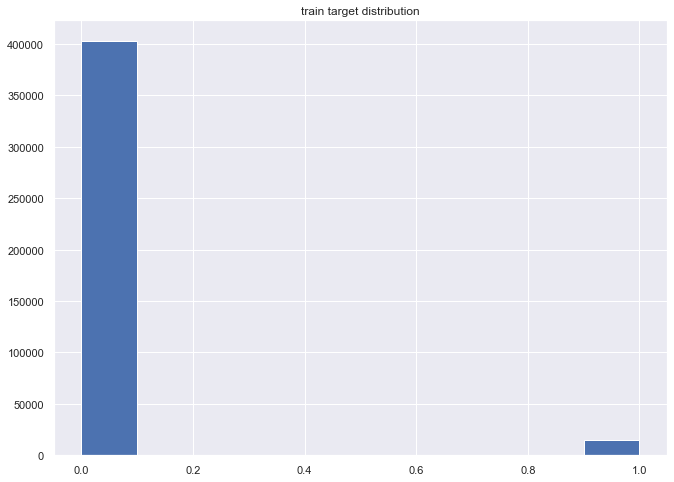

In [20]:
plt.figure(figsize=(11, 8))
plt.title('train target distribution')
plt.hist(y_train)
plt.show()

Можно заметить, что данные содержат признак, отвечающий за момент времени совершения транзакции - `'TransactionDT'`. Изучим его подробнее.

In [21]:
df_train['TransactionDT'].min(), df_test['TransactionDT'].max(), df_test['TransactionDT'].max() - df_train['TransactionDT'].min()

(86400, 15811131, 15724731)

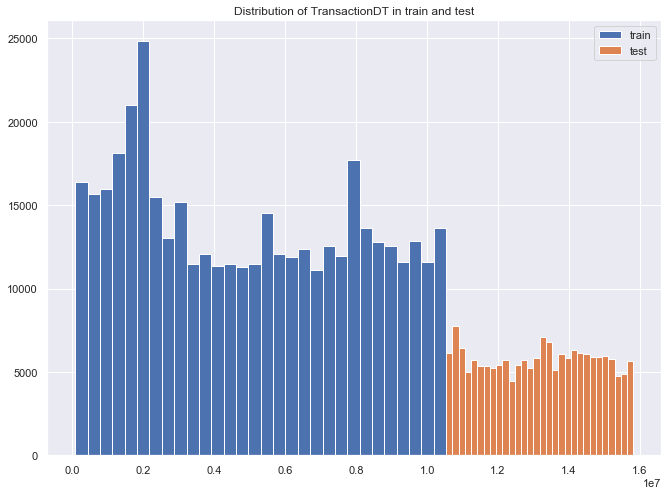

In [22]:
plt.figure(figsize=(11, 8))
plt.title('Distribution of TransactionDT in train and test')
plt.hist(df_train['TransactionDT'], label='train', bins=30)
plt.hist(df_test['TransactionDT'], label='test', bins=30)
plt.legend(loc='best')
plt.show()

Можно предположить, что время для этого признака измеряется в секундах, тогда похоже на то, что данные из трейна и теста - это данные за полгода.

In [23]:
(df_test['TransactionDT'].max() - df_train['TransactionDT'].min()) / (3600 * 24)

181.99920138888888

Также, если время измеряется в секундах, то, судя по всему, обучающая часть выборки включает в себя данные за 4 месяца, а тестовая - за следующие 2:

In [24]:
(df_train['TransactionDT'].max() - df_train['TransactionDT'].min()) / (3600 * 24), (df_test['TransactionDT'].max() - df_test['TransactionDT'].min()) / (3600 * 24)

(120.99996527777778, 60.998900462962965)

Построим распределения различных признаков.

In [ ]:
%%time

c_features = [col for col in df_train.columns if col.startswith('C')]
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 18))
for i in range(len(c_features)):
    col = c_features[i]
    j1 = i // 3
    j2 = i % 3
    ax = axes[j1, j2]
    ax.set_title(col)
    ax.scatter(df_train['TransactionDT'], df_train[col], s=8, label='train')
    ax.scatter(df_test['TransactionDT'], df_test[col], s=8, label='test')
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
%%time

d_features = [col for col in df_train.columns if col.startswith('D')][:-2]
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 18))
for i in range(len(d_features)):
    col = d_features[i]
    j1 = i // 3
    j2 = i % 3
    ax = axes[j1, j2]
    ax.set_title(col)
    ax.scatter(df_train['TransactionDT'], df_train[col], s=8, label='train')
    ax.scatter(df_test['TransactionDT'], df_test[col], s=8, label='test')
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(11, 8))
plt.title('TransactionAmt distribution')
plt.scatter(df_train['TransactionDT'], df_train['TransactionAmt'], label='train')
plt.scatter(df_test['TransactionDT'], df_test['TransactionAmt'], label='test')
plt.legend(loc='best')
plt.show()

In [ ]:
%%time

cat_fts = ['ProductCD', 'card4', 'card6', 'DeviceType']
fig, ax = plt.subplots(nrows=len(cat_fts), ncols=2, figsize=(18, 10))
ax[0, 0].set_title('train')
ax[0, 1].set_title('test')
for i in range(len(cat_fts)):
    col = cat_fts[i]
    sns.countplot(x=col, ax=ax[i, 0], data=df_train)
    sns.countplot(x=col, ax=ax[i, 1], data=df_test)
plt.tight_layout()
plt.show()

Посмотрим на то, как некоторые признаки связаны с целевой переменной. Это может помочь при генерации новых признаков.

In [ ]:
%%time

cols_target = ['P_emaildomain', 'R_emaildomain', 'ProductCD', 'card4', 'card6']

for col in cols_target:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
    unique_values = [x for x in list(set(df_train[col].values).intersection(set(df_test[col].values))) if str(x) != 'nan']
    sns.countplot(y=col, ax=ax[0], data=df_train.loc[df_train['isFraud'] == 1], order=unique_values)
    ax[0].set_title(col + ' & isFraud = 1')
    sns.countplot(y=col, ax=ax[1], data=df_train.loc[df_train['isFraud'] == 0], order=unique_values)
    ax[1].set_title(col + ' & isFraud = 0')
    plt.show()